In [1]:
#NUESTRO MODELO SE BASA EN LSTM (LONG SHORT TERM MEMORY) PARA PREDECIR LA COMPRA DE ACCIONES DE DIFERENTES COMPAÑIAS
#PRIMERO IMPORTAREMOS LAS LIBRERIAS CON LAS QUE ESTAREMOS TRABAJANDO
import math
import pandas_datareader as web #Nos servira para comparar lo que se encuentra en la pantalla con lo requerido
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
plt.style.use('fivethirtyeight') #Definimos un estilo para las graficas

In [2]:
#Cotizacion de acciones, obtenemos la informacion desde yahoo
df = web.DataReader('BIMBOA.MX', data_source='yahoo',start='2018-01-01',end='2022-05-05') #BIMBOA.MX son referentes a las acciones de bimbo tomando la referencia en yahoo
#Mostramos la informacion
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,43.750000,42.910000,43.720001,43.380001,1626731.0,40.470776
2018-01-03,43.650002,43.099998,43.220001,43.400002,1230572.0,40.489433
2018-01-04,44.000000,43.029999,43.650002,43.669998,2341379.0,40.741322
2018-01-05,44.000000,43.419998,43.770000,43.540001,3034896.0,40.620045
2018-01-08,43.970001,43.110001,43.639999,43.509998,1886857.0,40.592052
...,...,...,...,...,...,...
2022-04-29,63.509998,61.720001,62.189999,62.900002,3572648.0,62.200275
2022-05-02,67.400002,62.029999,62.980000,67.089996,3446660.0,66.343658
2022-05-03,66.989998,60.660000,66.989998,62.049999,5374881.0,61.359730


In [3]:
#Obtenemos el numero de filas y columnas con la que vamos a trabajar
df.shape

(1092, 6)

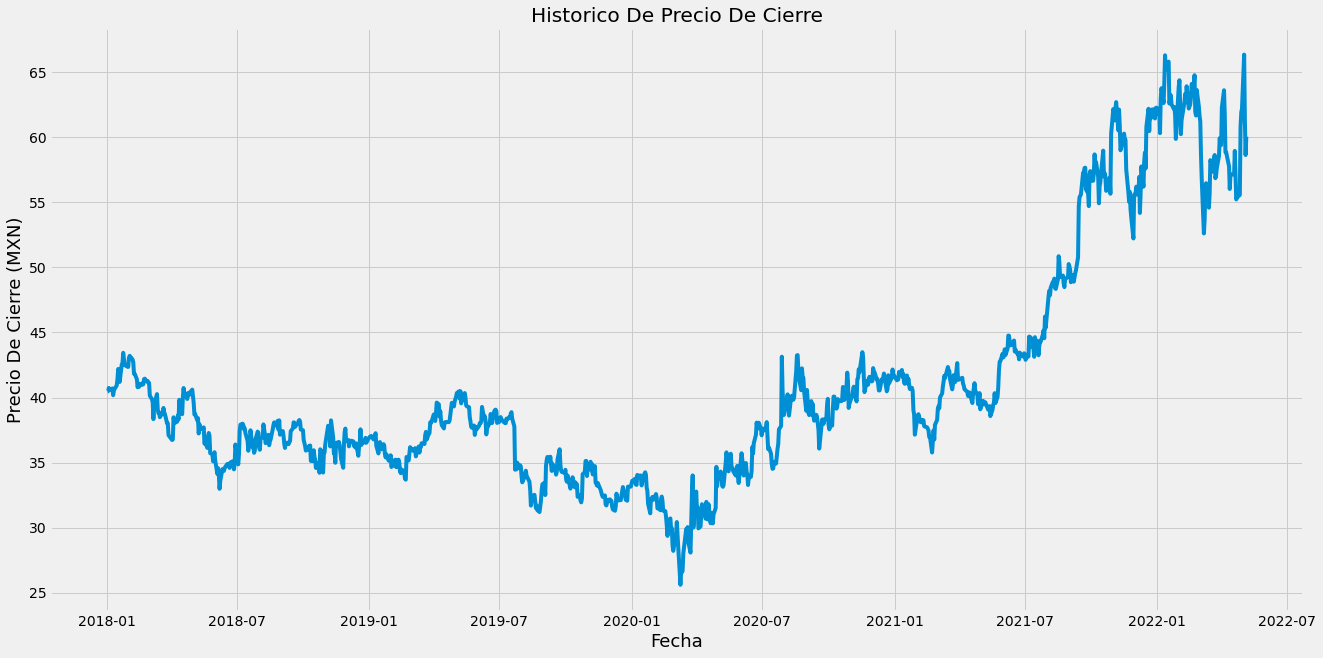

In [4]:
#Como queremos predecir el precio de apertura, trabajaremos con el precio de cierre de cada dia.
#Procedemos a realizar un visual que nos ayudara a comprender cual es el precio de cierre
plt.figure(figsize=(20,10))
plt.title('Historico De Precio De Cierre')
plt.plot(df['Adj Close'])
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio De Cierre (MXN)', fontsize=18)
plt.show()


In [5]:
#Haciendo un analisis, denotamos que la mejor fecha para comprar las acciones de bimbo fue entre enero del 2020 y
#Julio del 2020 en plena pandemia de coronavirus dado que alcanso un nivel bajo en precio por debajo de los 30 pesos
#Mexicanos por accion, y que si hubieramos vendido las acciones en algun punto a partir de enero del 2020, hubieramos
#Tenido un buen margen de ganancia alrededor del doble o mas.

In [6]:
#Ahora bien crearemos un conjunto de datos con solo los datos de cierre por lo cual, debemos de filtrar del conjunto
#De datos solo la columna de Close que es el precio de cierre.
data = df.filter(['Adj Close'])
#Ahora pasamos a convertirlo en un array para poder trabajar mas comodamente con los datos
dataset = data.values
#Ahora calcularemos el numero de filas que se estan trabajando para tener una referencia de el numero de valores a
#entrenar con nuestro modelo que ademas solo trabajaremos con el 75% del volumen de los datos.
training_data_len = math.ceil(len(dataset) * (0.75)) #math ceil permitira redondear hacia arriba el valor y trabajar numeros enteros
training_data_len #Imprimimos el valor

819

In [7]:
#Ahora escalamos los datos para trabajarlos entre 0 y 1 y de esta manera clasificar de mejor manera
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)#Transformamos nuestro conjunto de datos que nos serviran para 
                                    #modificar los valores de los datos y ajustarlos de la manera que se aproximen mas a lo que se requiere

scaled_data #Imprimimos    

array([[0.36468026],
       [0.36513841],
       [0.37132363],
       ...,
       [0.87761749],
       [0.81059842],
       [0.84507919]])

In [8]:
#Ahora crearemos el conjunto de datos de entrenamiento
#Primero crearemos el conjunto de datos escalados de entrenamiento para poder trabajar de mejor manera los datos
train_data = scaled_data[0:training_data_len, :] #Contendra todos los datos desde el indice hasta el valor de numero de filas que calculamos previamente
#Ahora dividiremos los datos en x_train, y_train para trabajarlo de mejor manera
x_train = [] #Se declara el arreglo de entrenamiento x
y_train = [] #Se declara el arreglo de entrenamiento x
#Mediante un bucle for, llenaremos los arreglos de entrenamiento en x , y
for i in range(60, len(train_data)): #El numero 60, se refiere a los ultimos 60 valores, puede modificarse a las necesidades requeridas
    x_train.append(train_data[i-60:i, 0]) #i-60 es el ultimo valor desde el conjunto de datos : significa hasta i, donde se recorrera 60 valores para llenar el conjunto
    y_train.append(train_data[i,0])#Donde obtendra el valor de i actual
    if i<=61: #Si I ya recorrio los primeros o ultimos 60 valores entonces imprime el contenido
        print(x_train)
        print(y_train)
        print()#Valor mejor ajustado a prediccion

[array([0.36468026, 0.36513841, 0.37132363, 0.36834563, 0.36765827,
       0.37040743, 0.35757855, 0.36628382, 0.36926192, 0.3761347 ,
       0.38804709, 0.40706119, 0.39973046, 0.38254895, 0.41553734,
       0.41828651, 0.43752983, 0.42630451, 0.41485017, 0.41187198,
       0.4150792 , 0.41095568, 0.42859525, 0.43180256, 0.42492988,
       0.41966095, 0.39789787, 0.3981268 , 0.38758885, 0.37269826,
       0.37773807, 0.37338562, 0.37911261, 0.3770509 , 0.38025812,
       0.37819631, 0.38804709, 0.38873436, 0.38346543, 0.38438163,
       0.38140353, 0.38071636, 0.35689129, 0.34978958, 0.3440625 ,
       0.31244836, 0.3390225 , 0.34566606, 0.35964036, 0.3310045 ,
       0.32367377, 0.32527724, 0.31611382, 0.3250484 , 0.33352455,
       0.32481909, 0.32207021, 0.30465948, 0.30465948, 0.28220904])]
[0.2730456196734564]

[array([0.36468026, 0.36513841, 0.37132363, 0.36834563, 0.36765827,
       0.37040743, 0.35757855, 0.36628382, 0.36926192, 0.3761347 ,
       0.38804709, 0.40706119, 0.399

In [9]:
#Una vez obtenidos los valores para x_train y_train, convertamos estos en arreglos para trabajarlos.
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#Ahora que tenemos los datos como los queremos, tenemos que remodelarlos ya que el modelo lstm, trabaja sobre 
#Esquemas tridimensionales donde es necesario que los datos se acoplen, por lo cual es necesario este paso.
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) #Donde como parametros usamos x_train, 759 y 60 sale usando x_train.shape y 1 sale del numero de funciones a utilizae
                                        #En este caso 1 ya que solo buscamos el precio de cierre

x_train.shape #Imprimimos para checar argumentos

(759, 60, 1)

In [11]:
#Ahora nos pasaremos a contruir el modelo LSTM
model = Sequential() #Creamos el modelo secuencial vacio
model.add(LSTM(50, return_sequences = True , input_shape=(60, 1)))
model.add(LSTM(50, return_sequences = False)) 
model.add(Dense(25))
model.add(Dense(1))#Capa de salida

In [12]:
#Compilacion del modelo creado
model.compile(optimizer='adam',loss='mean_squared_error')

In [13]:
#Ahora entrenaremos al modelo utilizando ajustes de los parametros
model.fit(x_train,y_train,batch_size=1,epochs=1)

759/759 [==============================] - 46s 48ms/step - loss: 0.0016


In [22]:
#Una vez entrenado el modelo procedemos a crear un conjunto de datos con el cual trabajar
#Ahora haremos un nuevo dataframe que contenga los valores escalados restante de los valores que usamos con anterioridad
#Es decir, desde 759 hasta 1092
test_data = scaled_data[training_data_len - 60:, :]
#Ahora creamos un conjunto de datos para x_train y_train
x_test = []
y_test = dataset[training_data_len:, :]
#Ahora llenaremos los datos mediante el uso de un bucle
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [24]:
#Ahora convertimos el conjunto de datos en un arreglo para que sea mas manejable al momento de utilizarlo
x_test = np.array(x_test)

In [27]:
#Despues lo remodelamos ya que como se menciono con anterioridad el modelo LSTM solo trabaja con datos de caracter dimensional
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [28]:
#Ahora con los ajustes necesarios hechos, procedemos a usar la funcion de prediccion para poder trabajar con el modelo
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [29]:
#Ahora obtendremos el error cuadrado medio con el cual podemos trabajar
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse #Imprimimos

1.1990354349324992

In [36]:
#Ahora imprimimos los datos de manera que podamos verlo de forma historica con la funcion plot
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions #Agregamos una nueva columna llamada predictions que isara los datos que hicimos anteriormente

C:\Users\Richa\AppData\Local\Temp\ipykernel_3616\3057883728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions #Agregamos una nueva columna llamada predictions que isara los datos que hicimos anteriormente


KeyError: ('Adj Close', 'Predictions')

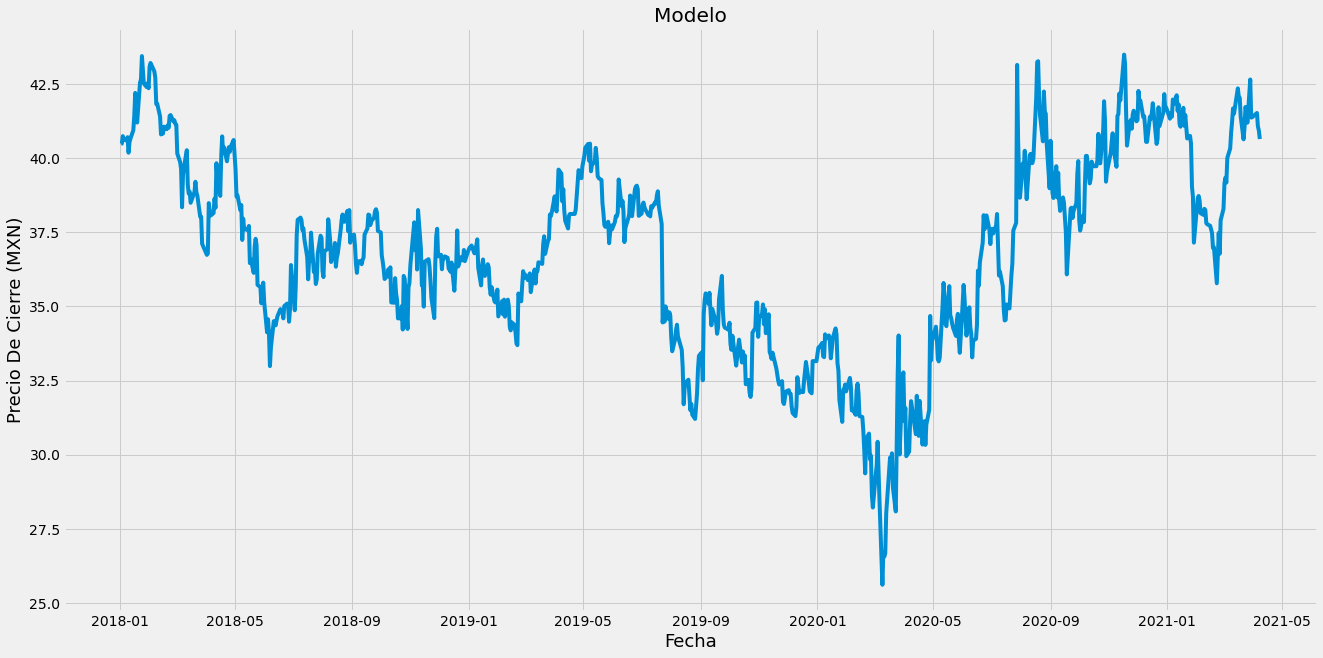

In [39]:
#Ahora mostramos y configuramos el grafico a visualizar
plt.figure(figsize=(20,10))
plt.title('Modelo')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio De Cierre (MXN)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid['Adj Close','Predictions'],fontsize=18)
plt.legend(['Train','Val','Prediction'],loc = 'lower right')#Train es el conjunto de entrenamiento, val valor actual y prediction es el valor de predicion
plt.show() #Mostramos el grafico

In [40]:
#Mostramos los valores que esta prediciendo
valid

,Adj Close,Predictions
Date,,
2021-04-09,40.594074,40.634514
2021-04-12,40.430115,40.478256
2021-04-13,40.121490,40.320164
2021-04-14,40.381893,40.141850
2021-04-15,40.391537,40.018082
...,...,...
2022-04-29,62.200275,56.692963
2022-05-02,66.343658,57.912205
2022-05-03,61.359730,59.664452


#### AHORA LO PONDREMOS A PRUEBA

In [42]:
#Obtenemos los datos de bimbo
bimbo = web.DataReader('BIMBOA.MX', data_source='yahoo',start='2018-01-01',end='2022-05-05') #BIMBOA.MX son referentes a las acciones de bimbo tomando la referencia en yahoo
#Creamos un nuevo conjunto de datos
new_df = bimbo.filter(['Adj Close'])
#Obtenemos los valores de cierre de los ultimos 60 dias (se puede modificar)
last_60_days = new_df[-60:].values
#Escalamos los datos para trabajar mas facilmente con ellos
last_60_days_scaled = scaler.transform(last_60_days)
#Creamos un conjunto vacio para almacenar datos
X_test = []
#Agregamos los valores de los ultimos 60 dias
X_test.append(last_60_days_scaled)
#Convertimos el conjunto en un arreglo para pasarlo al modelo
X_test = np.array(X_test)
#Remodelamos los datos para pasarlo al modelo
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Obtenemos el valor de prediccion
pred_price = model.predict(X_test)
#Escalamos los datos nuevamente
pred_price = scaler.inverse_transform(pred_price)
pred_price #Imprimimos

array([[60.195732]], dtype=float32)